<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# OpenEO Platform - User Story 2
### Interactive timeseries trajectory analysis from pre-computed ARD data

1. Timeseries visualization from EODC and VITO using precomputed data.
2. Landsat + Sentinel-1 + Sentinel-2
3. Show NDVI timeseries from Landsat and Sentinel-2. Plus gamma for Sentinel-1 (sigma to gamma ratio?).
4. Connect also to EURAC back-end and show the difference with s2cloudless data.

QUESTION TO THE DEV MEETING:

- EODC, how to turn on/off cloud masking?


In [10]:
# Import necessary libraries
import time
import rasterio
import numpy as np
import xarray as xr
import openeo
from ipyleaflet import *
from ipywidgets import *
from traitlets import link
import shapely.geometry
from bqplot import Lines, Figure, LinearScale, DateScale, Axis
from datetime import datetime
import json

## Run the next cell and select the Area Of Interest using the rectangle button.

In [15]:
label = Label(value='[*] Loading data from OpenEO...')
def openeo_timeseries(feature_collection,band_name='B04',init=False):
    global label
    if not init:
        display(label)
    else:
        label.value = '[*] Loading data from OpenEO...'
    connection = openeo.connect("https://openeo-dev.vito.be").authenticate_basic('guest','guest123')
    
    point_coords = feature_collection['features'][0]['geometry']['coordinates']
    cloudmask = connection.load_collection("SENTINEL2_L2A_SENTINELHUB",
                                     spatial_extent={'west':point_coords[0],'east':point_coords[0],'south':point_coords[1],'north':point_coords[1],'crs':'EPSG:4326'},
                                     temporal_extent=["2018-02-01", "2020-09-01"],
                                     bands=['CLM'])
    l1c = connection.load_collection("SENTINEL2_L1C_SENTINELHUB",
            spatial_extent={'west':point_coords[0],'east':point_coords[0],'south':point_coords[1],'north':point_coords[1],'crs':'EPSG:4326'},
                                     temporal_extent=["2018-02-01", "2020-09-01"],
                                     bands=[band_name])
    l2a = l1c.mask(cloudmask).filter_bands(band_name)
    l2a.download("./openeo-rgb-l2a_pixel.nc", format="NETCDF")
    px_series = xr.open_dataset("./openeo-rgb-l2a_pixel.nc")
    date_start = px_series.t.min().values
    date_end = px_series.t.max().values

    x_scale = DateScale(min=date_start, max=date_end)
    y_scale = LinearScale()

    x_data = px_series.t.values
    y_data = px_series.to_array()[0,:,0,0].values

    x_data = x_data[~np.isnan(y_data)]
    y_data = y_data[~np.isnan(y_data)]
    x_data = x_data[y_data!=0]
    y_data = y_data[y_data!=0]

    lines = Lines(x=x_data, y=y_data, scales={'x': x_scale, 'y': y_scale})

    ax_x = Axis(label='Year', scale=x_scale, num_ticks=10, tick_format='%Y')
    ax_y = Axis(label='Band', scale=y_scale, orientation='vertical', side='left')

    figure = Figure(axes=[ax_x, ax_y], title='Band ' + band_name + ' timeseries', marks=[lines], animation_duration=1000,
                        layout={'max_height': '250px', 'width': '600px'})
    label.value = '[*] Data loaded successfully!'
    return figure, l2a.to_graphviz()

center = [ 46.342738, 11.411711]
zoom = 11
m = Map(center=center, zoom=zoom)
feature_collection = {
    'type': 'FeatureCollection',
    'features': []
}

draw = DrawControl(
    circlemarker={}, polyline={}, polygon={}, rectangle={},
    marker = {"shapeOptions": {
               "original": {},
               "editing": {},
    }})

m.add_control(draw)
init           = False
widget_control = None
l2a            = None

def handle_draw(target, action, geo_json):
    global init, widget_control, l2a
    if init:
        m.remove_control(widget_control)
    feature_collection['features'] = []
    feature_collection['features'].append(geo_json)
    figure, l2a = openeo_timeseries(feature_collection,band_name,init)
    widget_control = WidgetControl(widget=figure, position='bottomright')
    m.add_control(widget_control)
    if not init:
        m.add_control(basemap_control)
    init = True

# Adds a Dropdown widget
bands = ['B08','B04','B02']
band_name = 'B04'
dropdown = Dropdown(
    options=bands,
    value='B04',
    description='Bands'
)

# Handles Dropdown control event
def on_click(change):
    global band_name, l2a
    band_name = change['new']
    global init, widget_control
    if init:
        m.remove_control(widget_control)
    figure, l2a = openeo_timeseries(feature_collection,band_name,init)
    widget_control = WidgetControl(widget=figure, position='bottomright')
    m.add_control(widget_control)
    init = True    
dropdown.observe(on_click, 'value')

# Adds control to the map
basemap_control = WidgetControl(widget=dropdown, position='topright')
draw.on_draw(handle_draw)

display(m)

Map(center=[46.342738, 11.411711], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

Label(value='[*] Loading data from OpenEO...')

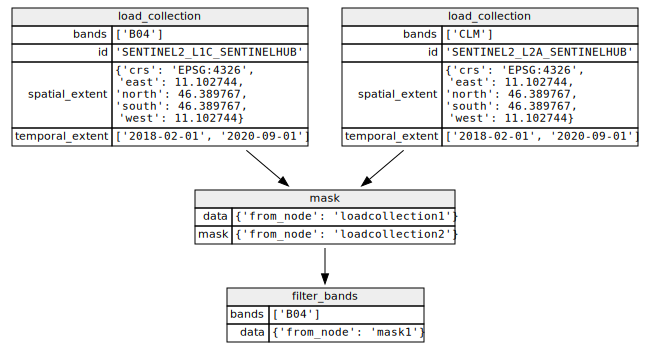

In [16]:
l2a